# Pneumonia prediction using Transfer Learning

In [ ]:
!pip install tensorflow-gpu

In [ ]:
tf.__version__

'2.3.0'

## Import lib

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
import keras

## Download dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"
with ZipFile(file_name) as zip:
  zip.extractall()
  print('Done')

 99% 2.28G/2.29G [00:46<00:00, 44.8MB/s]
100% 2.29G/2.29G [00:46<00:00, 52.5MB/s]
Done


In [ ]:
NORMAL_LABEL = 'Normal'
PNEUMONIA_LABEL = 'Pneumonia'

NORMAL_TRAIN_DIR = 'chest_xray/train/NORMAL'
PNEUMONIA_TRAIN_DIR = 'chest_xray/train/PNEUMONIA'

fixed_size = (256, 256)

X_train = []
y_train = []

In [ ]:
for img in tqdm(os.listdir(NORMAL_TRAIN_DIR)):
  path = os.path.join(NORMAL_TRAIN_DIR, img)
  img = cv2.imread(path)
  img = cv2.resize(img, fixed_size)  
  X_train.append(img)    
  y_train.append(NORMAL_LABEL)

for img in tqdm(os.listdir(PNEUMONIA_TRAIN_DIR)):
  path = os.path.join(PNEUMONIA_TRAIN_DIR, img)
  img = cv2.imread(path)
  img = cv2.resize(img, fixed_size)  
  X_train.append(img)    
  y_train.append(PNEUMONIA_LABEL)

In [ ]:
len(y_train)

5216

In [ ]:
vgg19 = VGG19(input_shape=[224,224,3], weights='imagenet', include_top=False)
for layer in vgg19.layers:
  layer.trainable = False
X = Flatten()(vgg19.output) 
output = Dense(2, activation='softmax')(X) 
model = Model(inputs=vgg19.input, outputs=output)

In [ ]:
TRAIN_DIR = 'chest_xray/train'
TEST_DIR = 'chest_xray/test'

target_size = (224, 224)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.run_eagerly = False
train_datagen = ImageDataGenerator(rescale = 1/255, shear_range = .2, zoom_range = .2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1/255) 
train_data = train_datagen.flow_from_directory(TRAIN_DIR, target_size = target_size, batch_size = 32, class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(TEST_DIR, target_size = target_size, batch_size = 32, class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
# tf.compat.v1.disable_eager_execution()
with tf.device("/gpu:0"):
  history = model.fit(train_data, validation_data=test_data, epochs=50)

Epoch 1/50
163/163 [==============================] - 130s 796ms/step - loss: 0.1381 - accuracy: 0.9475 - val_loss: 0.4864 - val_accuracy: 0.8462
Epoch 2/50
163/163 [==============================] - 127s 778ms/step - loss: 0.1193 - accuracy: 0.9557 - val_loss: 0.2713 - val_accuracy: 0.9135
Epoch 3/50
163/163 [==============================] - 127s 780ms/step - loss: 0.0998 - accuracy: 0.9632 - val_loss: 0.2677 - val_accuracy: 0.9183
Epoch 4/50
163/163 [==============================] - 126s 775ms/step - loss: 0.1009 - accuracy: 0.9622 - val_loss: 0.3947 - val_accuracy: 0.8910
Epoch 5/50
163/163 [==============================] - 126s 775ms/step - loss: 0.0872 - accuracy: 0.9668 - val_loss: 0.2663 - val_accuracy: 0.9167
Epoch 6/50
163/163 [==============================] - 126s 772ms/step - loss: 0.0877 - accuracy: 0.9686 - val_loss: 0.5572 - val_accuracy: 0.8638
Epoch 7/50
163/163 [==============================] - 128s 785ms/step - loss: 0.1242 - accuracy: 0.9576 - val_loss: 0.4483 -

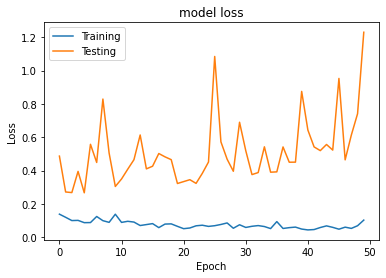

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

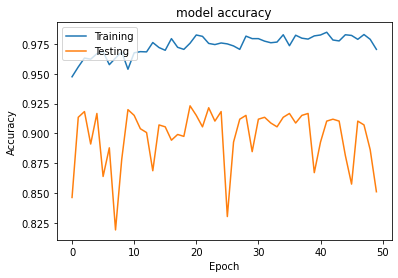

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

In [ ]:
MODEL_FILENAME = 'pneumonia.h5'

In [ ]:
model.save(MODEL_FILENAME)

In [ ]:
from keras.models import load_model
model = load_model('pneumonia.h5')

In [ ]:
input_img = cv2.imread('person21_virus_52.jpeg')
input_img = cv2.resize(input_img, (224, 224))
input_img = np.expand_dims(input_img, 0)
pred = model.predict(input_img)
pred = np.argmax(np.round(pred), axis=1)
pred[0]

1

# Evaluate model

In [ ]:
X_test = []
y_test = []
NORMAL_TEST_DIR = 'chest_xray/test/NORMAL'
PNEUMONIA_TEST_DIR = 'chest_xray/test/PNEUMONIA'

for img in tqdm(os.listdir(NORMAL_TEST_DIR)):
  path = os.path.join(NORMAL_TEST_DIR, img)
  img = cv2.imread(path)
  img = cv2.resize(img, target_size)   
  X_test.append(img)
  y_test.append("0") 

for img in tqdm(os.listdir(PNEUMONIA_TEST_DIR)):
  path = os.path.join(PNEUMONIA_TEST_DIR, img)
  img = cv2.imread(path)
  img = cv2.resize(img, target_size)   
  X_test.append(img)
  y_test.append("1") 

In [ ]:
X_test = np.array(X_test)
print(X_test.shape)
X_test[:,:,:,:]

In [ ]:
X_test = np.array(X_test)  
y_test = np.array(y_test) 
predicted_classes = model.predict(X_test[:,:,:,:]) 
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes[0]
y_test = y_test.astype('int64') 
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(predicted_classes,y_test) 

0.7275641025641025

In [ ]:
print(classification_report(y_test, predicted_classes, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.72      0.45      0.55       234
   Pneumonia       0.73      0.89      0.80       390

    accuracy                           0.73       624
   macro avg       0.72      0.67      0.68       624
weighted avg       0.73      0.73      0.71       624





		0 Class Represents Normal & 1 Class Represents Pnemonia


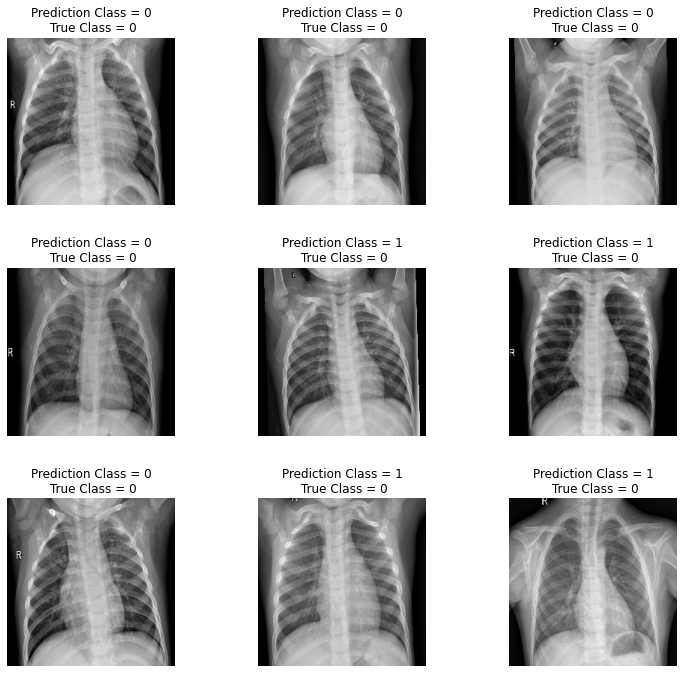

In [ ]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()
print('\n\n\t\t0 Class Represents Normal & 1 Class Represents Pnemonia')
for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]}\n True Class = {y_test[i]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# Convert TF model to TF Lite
(for Raspberry Pi)

In [ ]:
!ls -la

total 22544
drwxr-xr-x 1 root root     4096 Dec 14 16:32 .
drwxr-xr-x 1 root root     4096 Dec 14 16:31 ..
drwxr-xr-x 1 root root     4096 Dec 10 17:17 .config
-rw-r--r-- 1 root root 23068672 Dec 14 16:35 pneumonia_v2.h5
drwxr-xr-x 1 root root     4096 Dec  2 22:04 sample_data


In [ ]:
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

In [ ]:
model_keras = load_model('pneumonia.h5')
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_keras)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp15i309po/assets


In [ ]:
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!pip install https://github.com/google-coral/pycoral/releases/download/release-frogfish/tflite_runtime-2.5.0-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 1.3MB 788kB/s 


In [ ]:
from tflite_runtime.interpreter import Interpreter

In [ ]:
interpreter = Interpreter('tflite_model.tflite')
interpreter.allocate_tensors()

In [ ]:
_, height, width, _ = interpreter.get_input_details()[0]['shape']
height, width

(224, 224)

In [ ]:
img = cv2.imread('normal.jpeg')
img = cv2.resize(img, (width, height))
img = np.expand_dims(img, 0)
input_tensor = img.astype('float32')

In [ ]:
input_tensor.shape

(1, 224, 224, 3)

In [ ]:
!curl -O https://storage.googleapis.com/download.tensorflow.org/models/tflite/mobilenet_v1_1.0_224_quant_and_labels.zip
!unzip mobilenet_v1_1.0_224_quant_and_labels.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2997k  100 2997k    0     0  10.8M      0 --:--:-- --:--:-- --:--:-- 10.8M


In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
output_details

[{'dtype': numpy.float32,
  'index': 59,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
#set the tensor to point to the input data to be inferred
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_index, input_tensor)

In [ ]:
#Run the inference
interpreter.invoke()
output_details = interpreter.get_output_details()[0]
output = np.squeeze(interpreter.get_tensor(output_details['index']))
output

array([1., 0.], dtype=float32)

In [ ]:
np.argmax(interpreter.get_tensor(output_details['index']), axis=1)[0]

0

In [ ]:
np.argmax(np.round(output))

1